Presenting the results from the galaxy type classification. 
First I load the data. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
import time
import random as random
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
from functions_ml import *

Below I get the data, which is produced by the program get_zoo_galaxies.py.  The is applied  43 times and thus gets data from 43 fields. This fields cover the area from 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26  degree in Declination. 

The data consist of two pieces, firstly the images, which were saved as 4 dimensions (1 dimension x of image, second y of image, third channels, forth image in order or batch on torch language) numpy arrays, because torch needs 4d arrays, even when as here only a single channel exist. The image are rdeep images from http://research.iac.es/proyecto/stripe82/pages/data.php
This channel is the channel combination with the highest snr. Secondly information on each iamges is loaded as data frame, that are in particular the calseses spiral and elliptical which are bollean and exclusive here. There are citizen zoo classifications from the zoo projects. Only rather certain ones I included here, but there is no 100% certainty. 

In [2]:
#getting the list of images
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_im.npy') ]
list_images.sort()
#getting the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_table.csv')]
list_tables.sort()

I combine the images and the data frames, with the classifications and more meta data. 

In [3]:
#images
cutouts=comb_nump_4d(list_images)
#dataframes 
list_df=[]
for i in range(len(list_tables)):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}") 
df=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df.shape}")
print(f"shape of image file is {cutouts.shape}")

number of tables is 43
shape of combined data frame (7875, 51)
shape of image file is (43, 43, 1, 7875)


The images and the classification data has the same lengths. Now I am looking on classes.

In [4]:
print(df.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


The classes are somewhat inbalanced, the ones which are not spiral are ellipticals. 

Next I display some examples. There arer two classes of galaxies, elliptical and Spiral.

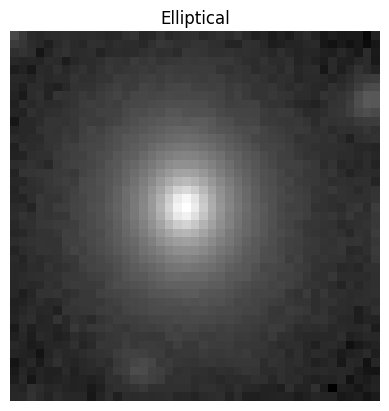

In [5]:
x=0
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

This elliptical is rather round, but others are more elongated but never exteremly. 

Spiral look rather different dependent on the angle, they are viwed on. 

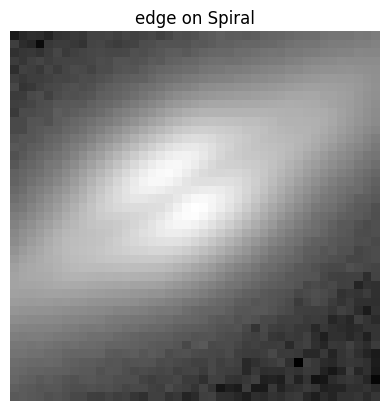

In [6]:
x=7870
plt.axis('off')
plt.title(f"edge on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

The dark strip in the center is not always visible in practice. 

The name giving spiral structure is visible face on. 

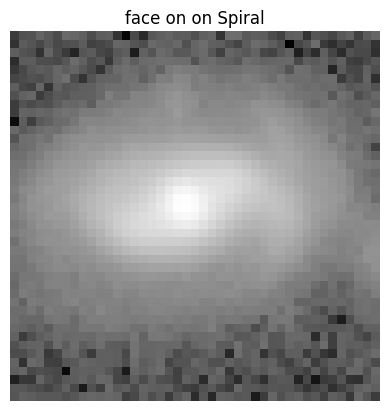

In [7]:
x=18
plt.axis('off')
plt.title(f"face on on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.125,cmap=cm.gray, interpolation='nearest')

However, some spirals only display other deviations from the simple structures of ellipticals, like rings.  

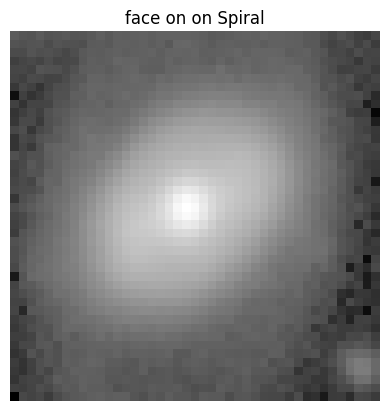

In [8]:
x=7874
plt.axis('off')
plt.title(f"face on on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.15,cmap=cm.gray, interpolation='nearest')

Thus, it is clear that there is a variation in structure between different examples of the same class. 



Next I add the image pixel information to the data frame, these data will be used by the algorithms which do not work on images but on tables. I Just run run two lopps within each other, thus the order is not particular meaningful. 

In [9]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1

/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_6737/536030214.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cut

Next I am splitting the data set into test and train. There are two feature variants, one is the standard tables for everything beisdes convolutional network and the other is the image data set for everything else. 

In [10]:
#images_test/train are feature for vonvolutional network 
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data is")
print(image_train.shape)

shape of image train data is
(4725, 1, 43, 43)


Applying it on other test data, which includes more uncertain classifications. 

I build a function for it.

In [25]:
#parameters, list of images, list of data frames with classes, model name
def predict_probs(images,classes,model,modelname='convolutional',keep_prob=1,num_features=1849):
    cutouts_new=comb_nump_4d(images).T
    print(cutouts_new.shape)
    list_df2=[]
    for i in range(len(classes)):
        i=pd.read_csv(classes[i])
        list_df2.append(i)  
    print(f"number of tables is {len(list_df2)}") 
    df2=pd.concat(list_df2,ignore_index=True)
    print(f"shape of combined data frame {df2.shape}")
    print(f"shape of image file is {cutouts_new.shape}")
    #if not convolutional add image columns to daat frame 
    if model!='convolutional':
        x=0
        for i in range(cutouts_new.shape[2]):
            for j in range(cutouts_new.shape[3]):
                df2[x]=cutouts_new[:,0,i,j]
                x+=1
    print(df2.shape)  
    image_rot,target_rot,df_rot=get_rot_mirror_all(cutouts_new,df2.ra,df2.iloc[:,0:52],shuffle=False)
    if modelname=='xgboost':
        #overwrite not use ones
        #image_rot=0
        target_rot=0
        xgb_reg=XGBClassifier()
        xgb_reg.load_model(model)
        pred_si=xgb_reg.predict_proba(df_rot.iloc[:,52:1901])
        #combine the 8 rotation entries 
        predboth=comb_entries(pred_si,8,avg=True)
        pred=predboth[:,1]
        print(df_rot.columns[52:1901],pred.shape)
    if modelname=='convolutional':
        #df_rot=0
        #setup data for torch 
        train_imrot_dataset = ClassificationDataset(torch.from_numpy(image_rot).float(), torch.from_numpy(np.array(target_rot)).float())
        train_imrot_loader_pred = DataLoader(dataset=train_imrot_dataset, batch_size=1)
        keep_prob=1
        model_convfin =CNNBinary4(keep_prob)
        model_convfin.load_state_dict(torch.load(model))
        model_convfin.eval()

        pred_si=pred_torch(model_convfin,train_imrot_loader_pred)
        pred=comb_entries(np.array(pred_si),8,avg=True)        
    return pred, df2, cutouts_new

In [13]:
images_allspec=['stripe82_27_allspec_im.npy']
classes_allspec=['stripe82_27_allspec_table.csv']
allspec_xpred,allspec_df,allspec_images=predict_probs(images_allspec,classes_allspec,'xgboost_model_spiral_ell_v1.json',modelname='xgboost')

(415, 1, 43, 43)
number of tables is 1
shape of combined data frame (415, 51)
shape of image file is (415, 1, 43, 43)


/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_5776/926181545.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

(415, 1900)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image', 'mirror_rot'],
      dtype='object')
(415, 52)
(3320, 52) Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r'

/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:469: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
Name: spiral, dtype: int64
count    3320.000000
mean        0.289157
std         0.453439
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: spiral, dtype: float64
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848],
      dtype='object', length=1849) (415,)


Now plotting the xgboost results.

(415, 1901) (154, 1901)


/tmp/ipykernel_12693/1021695740.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allspec_df['xgb_sp_prob']=allspec_xpred


Text(0, 0.5, 'xgboost spiral probability')

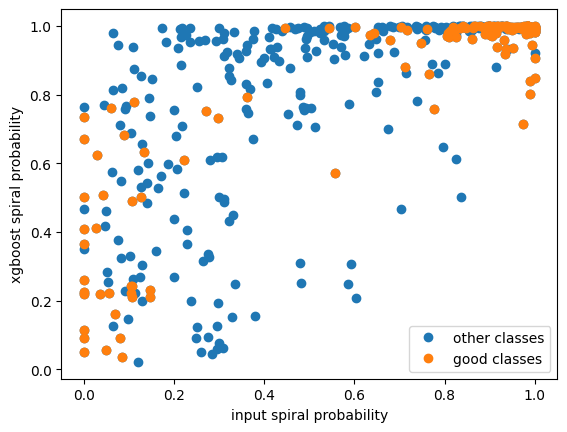

In [181]:
allspec_df['xgb_sp_prob']=allspec_xpred
allspec_dfgood=allspec_df[(allspec_df.spiral==1) | (allspec_df.elliptical==1)]
print(allspec_df.shape,allspec_dfgood.shape)
plt.plot(allspec_df.p_cs_debiased/(allspec_df.p_cs_debiased+allspec_df.p_el_debiased),allspec_df['xgb_sp_prob'],'o',label='other classes')
plt.plot(allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased),allspec_dfgood['xgb_sp_prob'],'o',label='good classes')
plt.legend(loc="best")
#plt.title('Test set')
plt.xlabel('input spiral probability')
plt.ylabel('xgboost spiral probability')

Not so clear results. Did everything worked correctly? 

In [182]:
#new_test_pred=np.array(pred_torch(model_convfin,new_test_imrot_loader))

Checking below whether here are more intermediate probabilities than in training set.

In [183]:
print((df.p_cs_debiased/(df.p_cs_debiased+df.p_el_debiased)).quantile([0.28,0.29,0.30]))
print((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased)).quantile([0.23,0.25,0.27]))

0.28    0.475265
0.29    0.551333
0.30    0.609121
dtype: float64
0.23    0.377960
0.25    0.567972
0.27    0.654575
dtype: float64


Is not, thus part worked. Looking now on confusion matrix. 

In [194]:
x_conf = confusion_matrix(np.round((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased))), np.round(allspec_dfgood['xgb_sp_prob']))
print(x_conf)
x_conf2 = confusion_matrix(np.round((allspec_dfgood.p_cs_debiased/(1))), np.round(allspec_dfgood['xgb_sp_prob']))
print(x_conf2)

[[ 22  15]
 [  0 117]]
[[ 22  15]
 [  0 117]]


Looks clearly different than in training/test data.

In [185]:
#there three which are spiral although the probabilties are not
print(154*-0.019481)
print((np.round((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased)))-allspec_dfgood.spiral).describe())
print((np.round(allspec_dfgood.p_cs_debiased)-allspec_dfgood.spiral).describe())

-3.0000739999999997
count    154.000000
mean      -0.019481
std        0.138657
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
dtype: float64
count    154.000000
mean      -0.019481
std        0.138657
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
dtype: float64


In [193]:
print(allspec_df['xgb_sp_prob'][0:10])
print(allspec_df.p_cs_debiased[0:10])
print(allspec_df.spiral[0:10])
print(allspec_df.elliptical[0:10])

0    0.780668
1    0.336830
2    0.992943
3    0.997730
4    0.986150
5    0.760384
6    0.805983
7    0.943360
8    0.267084
9    0.862694
Name: xgb_sp_prob, dtype: float64
0    0.725
1    0.153
2    0.682
3    0.504
4    0.175
5    0.058
6    0.647
7    0.072
8    0.148
9    0.605
Name: p_cs_debiased, dtype: float64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: spiral, dtype: int64
0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    0
8    0
9    0
Name: elliptical, dtype: int64


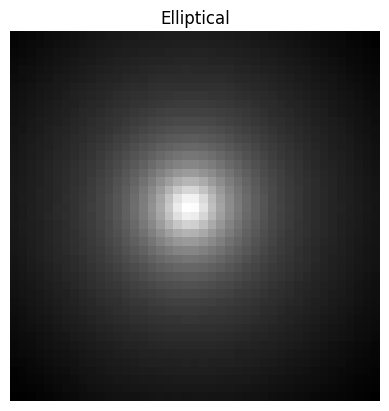

In [204]:
x=5
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

In [199]:
allspec_bad=allspec_dfgood[(np.round(allspec_dfgood.p_cs_debiased)!=np.round(allspec_dfgood['xgb_sp_prob']))]

In [214]:
print(allspec_bad.xgb_sp_prob)
print(allspec_bad.ra)
print(allspec_df.ra.describe())

5      0.760384
24     0.624668
33     0.508323
69     0.733522
80     0.792424
91     0.731413
109    0.502267
153    0.502039
227    0.669451
296    0.778942
301    0.994763
333    0.681720
369    0.608648
379    0.751834
397    0.632778
Name: xgb_sp_prob, dtype: float64
5      350.121145
24     350.033638
33     350.230281
69     350.649205
80     350.740539
91     350.845841
109    350.806561
153    351.118286
227    351.264887
296    351.843015
301    351.760498
333    352.210036
369    352.592333
379    352.936124
397    352.922403
Name: ra, dtype: float64
count    415.000000
mean     351.395366
std        0.820488
min      350.007801
25%      350.752780
50%      351.284812
75%      351.997239
max      352.990828
Name: ra, dtype: float64


Now looking on some images. One was there already above. 

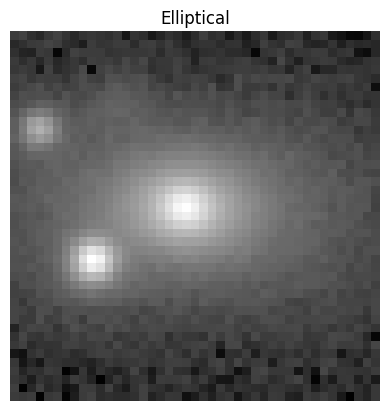

In [207]:
x=24
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

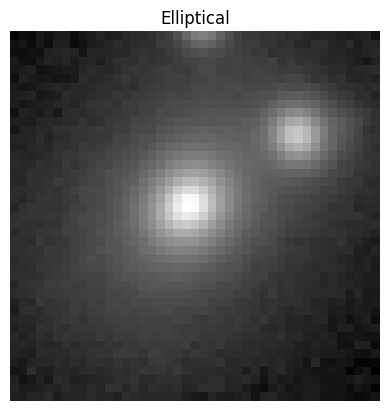

In [208]:
x=33
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

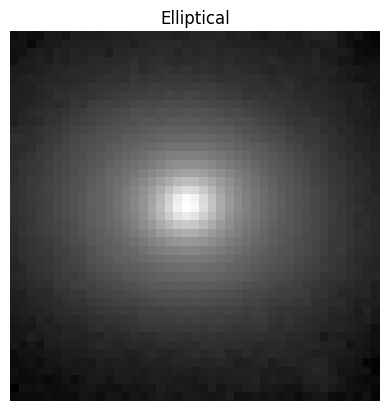

In [215]:
x=69
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

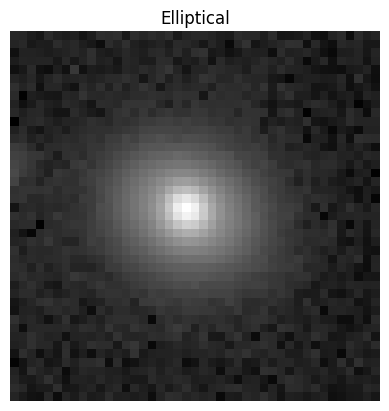

In [216]:
x=80
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

Some have more stars on them, but is that the reason? 

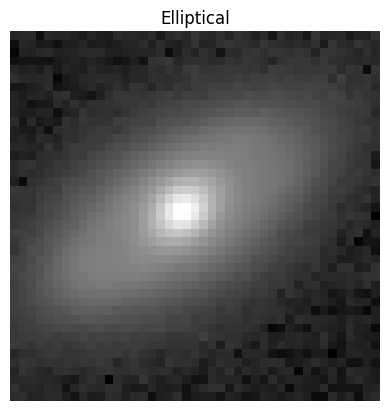

In [209]:
#This one does not look a clear elliptical, [robably a spiral ]
#is also classified as spiral certain  just not from probablity 
x=301
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

One is more likely galaxy but not more. 

Maybe is fine, thus doing convolutional now. 

In [12]:
images_allspec=['stripe82_27_allspec_im.npy']
classes_allspec=['stripe82_27_allspec_table.csv']
allspec_cpred,allspec_df,allspec_images=predict_probs(images_allspec,classes_allspec,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)

(415, 1, 43, 43)
number of tables is 1
shape of combined data frame (415, 51)
shape of image file is (415, 1, 43, 43)


/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/1510945918.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

(415, 1900)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image', 'mirror_rot'],
      dtype='object')
(415, 52)
(3320, 52) Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r'

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

(415, 1901) (154, 1901)


/tmp/ipykernel_6852/629800596.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allspec_df['conv_sp_prob']=allspec_cpred


Text(0, 0.5, 'convolutional spiral probability')

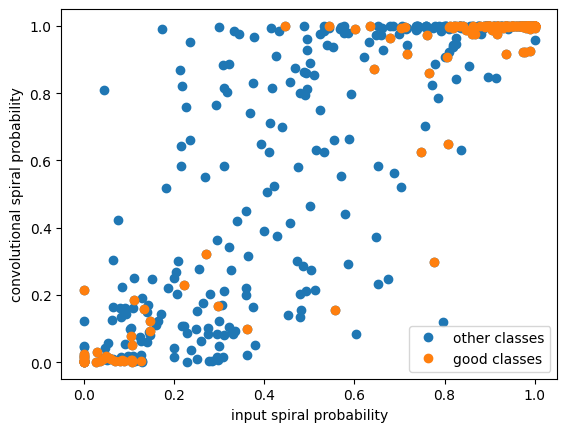

In [13]:
allspec_df['conv_sp_prob']=allspec_cpred
allspec_dfgood=allspec_df[(allspec_df.spiral==1) | (allspec_df.elliptical==1)]
print(allspec_df.shape,allspec_dfgood.shape)
plt.plot(allspec_df.p_cs_debiased/(allspec_df.p_cs_debiased+allspec_df.p_el_debiased),allspec_df['conv_sp_prob'],'o',label='other classes')
plt.plot(allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased),allspec_dfgood['conv_sp_prob'],'o',label='good classes')
plt.legend(loc="best")
#plt.title('Test set')
plt.xlabel('input spiral probability')
plt.ylabel('convolutional spiral probability')

Looks clearly better than xgboost. Either random xgboost or a independent problem there. 

In [14]:
c_conf = confusion_matrix(np.round((allspec_dfgood.p_cs_debiased/(allspec_dfgood.p_cs_debiased+allspec_dfgood.p_el_debiased))), np.round(allspec_dfgood['conv_sp_prob']))
print(c_conf)

[[ 36   1]
 [  2 115]]


In [21]:
allspec_cbad=allspec_dfgood[(np.round(allspec_dfgood.p_cs_debiased)!=np.round(allspec_dfgood['conv_sp_prob']))]
print(allspec_cbad.conv_sp_prob)
print(allspec_cbad.p_cs_debiased)
print(allspec_cbad.p_el_debiased)
#last one is a spiral with the one method and not with the other on zoo data
print(allspec_cbad.spiral)

81     0.296902
90     0.155257
301    0.998379
Name: conv_sp_prob, dtype: float64
81     0.777
90     0.528
301    0.446
Name: p_cs_debiased, dtype: float64
81     0.223
90     0.420
301    0.554
Name: p_el_debiased, dtype: float64
81     1
90     1
301    1
Name: spiral, dtype: int64


Looking on the not spirals. 

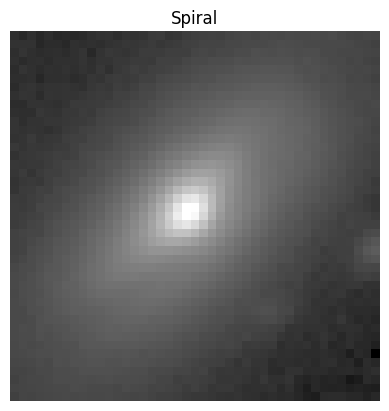

In [22]:
x=81
plt.axis('off')
plt.title(f"Spiral")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

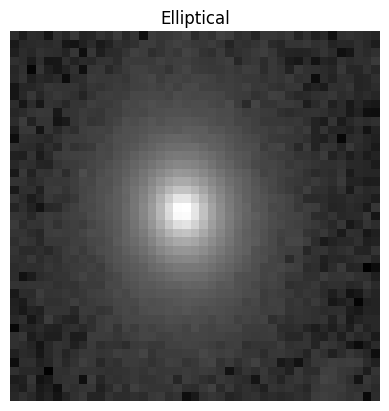

In [23]:
x=90
plt.axis('off')
plt.title(f"Spiral")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

81 is likely a Spiral, althought noit much substructure and so borderline, while 90 seems a clear elliptical.
Looking on more soon. 


Looking on stars. 

In [26]:

images_stars=['stripe82_27_stars_im.npy']
classes_stars=['stripe82_27_stars_table.csv']
stars_cpred,stars_df,stars_images=predict_probs(images_stars,classes_stars,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)

(599, 1, 43, 43)
number of tables is 1
shape of combined data frame (599, 48)
shape of image file is (599, 1, 43, 43)


/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cutouts_new[:,0,i,j]
/tmp/ipykernel_6852/3962014292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

(599, 1897)
Index([    'Unnamed: 0',          'index',          'objid',             'ra',
                  'dec',       'psfMag_u',       'psfMag_g',       'psfMag_r',
             'psfMag_i',       'psfMag_z',      'probPSF_u',      'probPSF_g',
            'probPSF_r',      'probPSF_i',      'probPSF_z',     'modelMag_u',
           'modelMag_g',     'modelMag_r',     'modelMag_i',     'modelMag_z',
           'petroRad_g',     'petroRad_r',     'petroRad_i',            'run',
                'rerun',         'camcol',          'field',           'type',
            'specobjid',          'class',       'subclass',       'redshift',
                 'zErr',       'zWarning',     'zErr_noqso', 'zWarning_noqso',
              'z_noqso',     'snMedian_r',     'snMedian_i',       'z_person',
         'class_person',          'plate',            'mjd',        'fiberid',
                'image',        'pixel_x',        'pixel_y',      'off_image',
           'mirror_rot',                

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[x]=image_all[:,0,i,j]
/home/tobias/ml-testing/astr-images/functions_ml.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

In [ ]:
Looking on probablities.

In [30]:
print(np.max(stars_cpred),np.mean(stars_cpred),np.median(stars_cpred))

0.1656909855082631 0.009391265594458957 0.0005097090224808198


All rather elliptical like, not so surprising, since stars have also no substructure. 